1. LSTM multiinput-series: https://www.aiproblog.com/index.php/2018/11/13/how-to-develop-lstm-models-for-time-series-forecasting/
2. LSTM train/test: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
3. Loss plotting: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
4. Overfit/Underfit: https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import LSTM
from keras.layers import Dense
import lightgbm as lgb
from scipy.stats import uniform, randint

In [67]:
def diagnostic_stats(ytrue, ypred):
    """
    https://stats.stackexchange.com/questions/142248/difference-between-r-square-and-rmse-in-linear-regression
    
    https://www.sciencedirect.com/topics/engineering/mean-bias-error
    """
    n = len(ytrue)

    # Check that the ytrue and ypred are equal length vector.
    assert n == len(ypred)
    
    # sum squared error
    sse = np.sum((ytrue - ypred)**2)
    
    # root mean square error
    rmse = np.sqrt(sse/n)

    # total sum of squares
    tss = np.sum((ytrue - np.mean(ytrue))**2)
    tst = np.sum((ypred - np.mean(ypred))**2)
    tstp = tst**0.5
    tssp = tss**0.5
    
    soorat = np.sum((ytrue-np.mean(ytrue))*(ypred-np.mean(ypred)))
    
    # Rsquare
    ##rsqr = 1 - sse/tss
    rsqr = (soorat/(tssp*tstp))**2

    # Mean biased error
    mbe = np.mean(ytrue - ypred)
    
    # IOAD
    num = np.sum((ytrue - ypred)**2)
    denom = np.abs(ytrue - ypred) + np.abs(ytrue + ypred)
    ioad = 1 - num/np.sum(denom**2)

    print("RMSE: %1.3f, R^2: %1.3f, MBE: %1.3f, IOAD: %1.3f"%(rmse, rsqr, mbe, ioad))
    
    return rmse, rsqr, mbe, ioad

In [68]:
train_df = pd.read_csv('train_layer2.csv', 
                 parse_dates=['DateTime'], index_col='DateTime')
train_df.drop('Unnamed: 0', axis=1, inplace=True)
train_df.sort_index(inplace=True)

test_df = pd.read_csv('test_layer2.csv', 
                 parse_dates=['DateTime'], index_col='DateTime')
test_df.drop('Unnamed: 0', axis=1, inplace=True)
test_df.sort_index(inplace=True)

In [69]:
train_df.head()

,0,1,2,3,4,5,Fc
DateTime,,,,,,,
2013-01-01 01:00:00,0.846773,0.918132,0.875012,0.883520,0.386506,0.730006,1.067198
2013-01-01 01:30:00,0.830835,0.868667,0.902072,0.871775,0.445869,0.735292,1.041434
2013-01-01 07:00:00,0.477854,0.376036,-0.285410,0.523461,0.539703,0.539797,0.391297
2013-01-01 07:30:00,-0.274316,0.163167,-0.431348,0.132327,0.257334,0.278477,1.339480
2013-01-01 08:00:00,-0.233189,-0.029411,-0.511897,-0.106105,0.043812,0.067382,1.230345


In [70]:
test_df.head()

,0,1,2,3,4,5,Fc
DateTime,,,,,,,
2013-03-21 02:30:00,1.223779,0.961175,1.041231,0.636519,0.516030,1.089910,2.088809
2013-03-21 03:00:00,0.951709,0.937124,0.965334,0.608987,0.615727,0.755521,0.552344
2013-03-21 04:00:00,1.138612,1.000614,0.964442,0.657209,0.586111,0.662852,1.241243
2013-03-21 08:00:00,0.546598,0.635507,0.659244,0.228027,0.463615,0.319815,0.410104
2013-03-21 08:30:00,-0.081457,0.215423,-0.397104,-0.311811,-0.030562,-0.427432,-0.338063


In [71]:
Xvar = ['0','1','2','3','4','5']
yvar = 'Fc'

### LSTM 

#### Data preparation

In [72]:
# split into input (X) and output (Y) variables
print('Train:', train_df.shape, 'Test:', test_df.shape)

X_train, y_train = train_df[Xvar], train_df[yvar]
X_test, y_test = test_df[Xvar], test_df[yvar]

print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print(X_train.keys())

scaler1 = StandardScaler()
X_train_scaled = scaler1.fit_transform(X_train)
scaler2 = StandardScaler()
y_train_scaled = scaler2.fit_transform(y_train.values.reshape(-1,1))
y_train_std, y_train_mean = np.std(y_train.values), np.mean(y_train.values)

scaler3 = StandardScaler()
X_test_scaled = scaler3.fit_transform(X_test)
scaler4 = StandardScaler()
y_test_scaled = scaler4.fit_transform(y_test.values.reshape(-1,1))
y_test_std, y_test_mean = np.std(y_test.values), np.mean(y_test.values)


Train: (3824, 7) Test: (1367, 7)
X_train: (3824, 6) y_train: (3824,)
Index(['0', '1', '2', '3', '4', '5'], dtype='object')


In [73]:
X_train_scaled.shape, y_train_scaled.squeeze().shape

((3824, 6), (3824,))

In [74]:
dataset_train = np.column_stack((X_train_scaled, y_train_scaled.squeeze()))
dataset_test = np.column_stack((X_test_scaled, y_test_scaled.squeeze()))

print(dataset_train.shape, dataset_test.shape)

(3824, 7) (1367, 7)


In [75]:
NSTEPS = 5
NFEATURES = len(Xvar)

In [76]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [77]:
# convert into input/output sequences
dataset_trainX, dataset_trainy = split_sequences(dataset_train, n_steps=NSTEPS)
print(dataset_trainX.shape, dataset_trainy.shape)

(3820, 5, 6) (3820,)


In [78]:
dataset_trainy

array([ 1.21976292,  0.3395728 , -0.37986877, ...,  0.86154897,
        0.78428415,  0.50438018])

#### Model fitting

In [79]:
# define model
model = Sequential()
#model.add(LSTM(2, activation='relu', input_shape=(NSTEPS, NFEATURES)))
model.add(LSTM(5, input_shape=(NSTEPS, NFEATURES)))
model.add(Dense(4, kernel_initializer='normal', activation='relu'))
model.add(Dense(1))    
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(dataset_trainX, dataset_trainy, 
                    validation_split=0.3, shuffle=False, 
                    epochs=100, batch_size=100, verbose=2)

Train on 2674 samples, validate on 1146 samples
Epoch 1/100
 - 3s - loss: 0.9777 - val_loss: 0.8979
Epoch 2/100
 - 0s - loss: 0.9277 - val_loss: 0.8161
Epoch 3/100
 - 0s - loss: 0.8664 - val_loss: 0.7200
Epoch 4/100
 - 0s - loss: 0.7987 - val_loss: 0.6187
Epoch 5/100
 - 0s - loss: 0.7325 - val_loss: 0.5228
Epoch 6/100
 - 0s - loss: 0.6762 - val_loss: 0.4420
Epoch 7/100
 - 0s - loss: 0.6347 - val_loss: 0.3800
Epoch 8/100
 - 0s - loss: 0.6072 - val_loss: 0.3352
Epoch 9/100
 - 0s - loss: 0.5896 - val_loss: 0.3040
Epoch 10/100
 - 0s - loss: 0.5775 - val_loss: 0.2823
Epoch 11/100
 - 0s - loss: 0.5689 - val_loss: 0.2665
Epoch 12/100
 - 0s - loss: 0.5626 - val_loss: 0.2545
Epoch 13/100
 - 0s - loss: 0.5581 - val_loss: 0.2447
Epoch 14/100
 - 0s - loss: 0.5547 - val_loss: 0.2368
Epoch 15/100
 - 0s - loss: 0.5523 - val_loss: 0.2308
Epoch 16/100
 - 0s - loss: 0.5505 - val_loss: 0.2262
Epoch 17/100
 - 0s - loss: 0.5491 - val_loss: 0.2225
Epoch 18/100
 - 0s - loss: 0.5479 - val_loss: 0.2196
Epoch 1

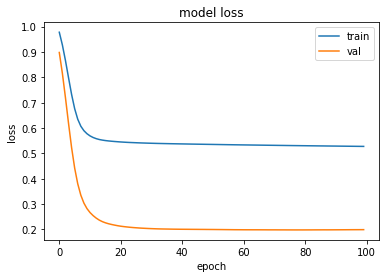

In [80]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [81]:
dataset_testX, dataset_testy = split_sequences(dataset_test, n_steps=NSTEPS)
yhat_test = model.predict(dataset_testX, verbose=0)

In [82]:
yhat_test.shape, dataset_testy.shape

((1363, 1), (1363,))

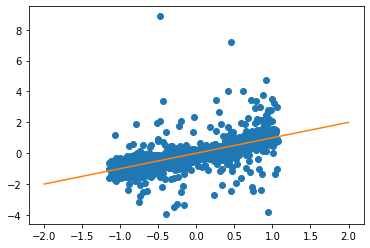

In [83]:
plt.plot(yhat_test.squeeze(), dataset_testy, 'o')
plt.plot([-2,2],[-2,2])

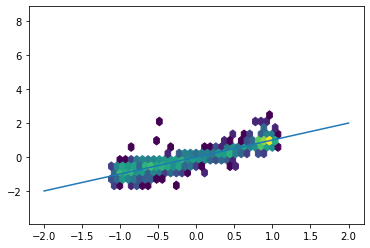

In [84]:
plt.hexbin(yhat_test.squeeze(), dataset_testy, mincnt=2, gridsize=30, bins='log')
plt.plot([-2,2],[-2,2])

#plt.plot([-2,2], [-2,2], 'r', lw=2)

In [90]:
print('LSTM: ')
diagnostic_stats(dataset_testy*y_test_std + y_test_mean, 
                 yhat_test.squeeze()*y_test_std + y_test_mean);

LSTM: 
RMSE: 0.718, R^2: 0.484, MBE: -0.012, IOAD: 0.884


#### Classical learning

In [86]:
def rmsle_randomsearchcv(model, params, X_train, y_train, n_folds, random_state=0):
    clf = RandomizedSearchCV(model, params, random_state=random_state, cv=n_folds, return_train_score=True, 
                         scoring="neg_mean_squared_error")
    search = clf.fit(X_train, y_train)
    rmse= np.sqrt(-search.best_score_)
    return rmse, search


In [87]:
# Hyperparameter Optz
params = dict(num_leaves = randint(2,10), 
              n_estimators = randint(100,1000),
              learning_rate = uniform(1e-3, 1),
              min_data_in_leaf = randint(2,10),
              objective=['regression'])

model_lgb = lgb.LGBMRegressor()
score_lgb, model_lgb = rmsle_randomsearchcv(model_lgb, params, dataset_train[:,:-1], 
                                            dataset_train[:,-1], 5)
print("\nLightGBM score: {:.4f} (+/-{:.4f})\n".format(score_lgb.mean(), score_lgb.std()))


LightGBM score: 0.6699 (+/-0.0000)



In [88]:
yhat_lgbm = model_lgb.predict(dataset_test[:,:-1])

print('LGBM')
diagnostic_stats(dataset_test[:,-1]*y_test_std + y_test_mean, 
                 yhat_lgbm*y_test_std + y_test_mean);

RMSE: 0.732, R^2: 0.466, MBE: -0.012, IOAD: 0.884


(0.7324523678462369,
 0.4663323909291778,
 -0.011602293906724718,
 0.8836502793660482)

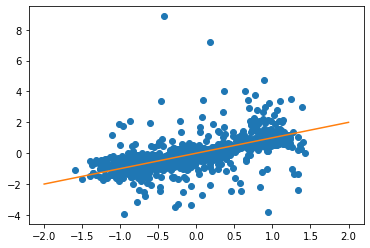

In [89]:
plt.plot(yhat_lgbm.squeeze(), dataset_test[:,-1], 'o')
plt.plot([-2,2],[-2,2])

In [91]:
print('LSTM: ')
diagnostic_stats(dataset_testy*y_test_std + y_test_mean, 
                 yhat_test.squeeze()*y_test_std + y_test_mean);
print('LGBM')
diagnostic_stats(dataset_test[:,-1]*y_test_std + y_test_mean, 
                 yhat_lgbm*y_test_std + y_test_mean);

LSTM: 
RMSE: 0.718, R^2: 0.484, MBE: -0.012, IOAD: 0.884
LGBM
RMSE: 0.732, R^2: 0.466, MBE: -0.012, IOAD: 0.884
